# Programming for Data Science
## Summative assignment 1: Social Network Analysis

### Introduction

The Walking Dead (TWD) and its spin-off shows, Fear the Walking Dead (FWD) and Walking Dead: World Beyond (WB), is a post-apocalyptic horror story in a contemporary setting. It is interesting from a network perspective as there is a lot of change to the core cast as people come in and out of the story, so the main protagonists are not static. There have been some previous network analyses of TV shows and the characters within, such as Bazzan, (2020), who analysed "Friends" and Beveridge and Shan, (2016), who analysed a Game of Thrones. Typically, the researchers will watch all the episodes and note down the characters and their interactions for later analysis. For this work, the Internet Movie DataBase (IMDB) will be used, which has a limit of the characters associated with each episode to four principal actors. However, there is no limit to the writers, so we can see whom the key influencers of the show are by analysing the writers and the principal actors.

Within the Logic of the Walking Dead Universe, Rick Grimes (Andrew Lincoln) is the main protagonist who is in all episodes up to series 9, episode 5; after this point, there is no clear main protagonist. In FWD, the main protagonist is Victor Strand (Coleman Domingo), and in WB, there is a core cast of four main characters, which is only one season long.



### Business problem 

By using network analysis, we will be able to identify the key influencers as well as the most important characters in the TV-series franchise "The Walking Dead".

#### Contents

- [Dataset creation](#create-data)
- [Summary statistics of the dataset](#summary-stats)
- [Analysis of whole network](#all)
- [Analysis of Cast only network](#cast-only)
- [Conclusion](#conclusion)
- [Further Work](#further-work)
- [Tests](#tests)
- [References](#references)
- [Equations](#equations)


In [2]:
# import all necessary packages

from itertools import combinations  # for creating combinations of actors
import matplotlib.pyplot as plt  # for plotting
import networkx as nx  # for analysing the network
import pandas as pd  # for data collection, sotrage and manipulation
import numpy as np
import lab_black  # for using the black code formatter
import gc  # for garbage collection when we require it.
import warnings  # to ignore deprecation warning, to have a clearner notebook

# to supress depreication warnings for a cleaner looking notebook
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
%load_ext lab_black

In [3]:
# Load compressed data from web source

# episode list
df_episodes = pd.read_csv(
    r"https://datasets.imdbws.com/title.episode.tsv.gz", compression="gzip", sep="\t"
)
# title of writers/directors
df_title = pd.read_csv(
    r"https://datasets.imdbws.com/title.akas.tsv.gz", compression="gzip", sep="\t"
)
# title of actors
df_actors = pd.read_csv(
    r"https://datasets.imdbws.com/title.principals.tsv.gz", compression="gzip", sep="\t"
)
# names of characters
df_names = pd.read_csv(
    r"https://datasets.imdbws.com/name.basics.tsv.gz", compression="gzip", sep="\t"
)

C:\TEMP\ipykernel_10860\1013084302.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_title = pd.read_csv(


In [4]:
# Find the identifier for the correct shows from the titles table
df_title[df_title.title.notna() & df_title.title.str.contains("Walking Dead")].head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
143824,tt0028478,14,The Walking Dead,CA,en,imdbDisplay,\N,0
143827,tt0028478,17,The Walking Dead,\N,\N,original,\N,1
143829,tt0028478,19,The Walking Dead,IN,en,imdbDisplay,\N,0
143833,tt0028478,22,The Walking Dead,AU,\N,imdbDisplay,\N,0
143836,tt0028478,4,The Walking Dead,GB,\N,imdbDisplay,\N,0


#### Shows for analysis

- Walking dead: "tt1520211"
- Fear the walking dead:  "tt3743822"
- The Walking Dead: World Beyond: tt10148174

<hr>

<a class="anchor" id="create-data"></a>

## Creating the dataset

In [5]:
# Filter the dataset so we only have the episodes from the show we are interested in
walking_eps = df_episodes[
    df_episodes.parentTconst.isin(["tt1520211", "tt3743822", "tt10148174"])
]

In [6]:
# merge the dataframes so we can match up the actors/writers with the episodes
df_dataset = walking_eps.merge(
    df_actors, how="left", left_on="tconst", right_on="tconst"
)

In [7]:
# refine the dataset so we only have the actors of interest
df_dataset = df_dataset[(df_dataset.category.isin(["actor", "actress", "writer"]))]

In [81]:
# Add names of cast/writers to the dataset
df_dataset = df_dataset.merge(
    df_names[["nconst", "primaryName"]], how="left", left_on="nconst", right_on="nconst"
)

In [82]:
# Save the relevant data to disc
df_dataset.to_csv("The_Walking_Dead_IMDB_dataset.csv")

In [85]:
# clean-up memory
del walking_eps, df_actors, df_episodes, df_names
gc.collect()

1513

<hr>

<a class="anchor" id="summary-stats"></a>

### Dataset summary statistics

In [4]:
# load data
df_dataset = pd.read_csv("The_Walking_Dead_IMDB_dataset.csv")

In [4]:
# Query to find number of unique roles per show, shortend for demonstration
df_dataset.query("parentTconst == 'tt1520211' & category == 'writer'").head(1)

,Unnamed: 0.1,Unnamed: 0,tconst,parentTconst,seasonNumber,episodeNumber,ordering,nconst,category,job,characters,primaryName
99,99,110,tt11156952,tt1520211,11,1,10,nm1764891,writer,written by,\N,Angela Kang


### Writers, actors and actresses

<center />Table 1: Counts of writers, actors and actressess in the IMDB dataset

|Show|Role|Count|
|--|--|--|
|The Walking Dead: World Beyond|writer|5|
||actor|2|
||actress|2|
|Fear the walking Dead|writer|40|
||actor|7|
||actress|8|
|The Walking Dead|writer|32|
||actor|6|
||actress|7|
|Total||109|


Due to the fact that only a subset of "Principal Actors" are available for each show, the writers of the shows outnumber the cast. There is a total of *99* unique entries in the dataset, therefore, there is some crossover of actors/writers between the shows. 


<hr>

<a class="anchor" id="all"></a>

### Analysis of the entire network


In [ ]:
# create the connections between crew in each episode by using the nconst identifier for each individual
# The dataframe should be the set or subset of shows/episodes we are interested in.
def create_connections(df: pd.DataFrame) -> pd.DataFrame:
    """
    returns a dataframe in which combinations of actors and writers are
    created for each episode
    :param df: pd.DataFrame
    :return: pd.DataFrame"""

    # list comprehension to create combinations
    connections = [
        [episode, x, y]
        for episode, names in df.groupby("tconst").nconst
        for x, y in combinations(names, 2)
    ]

    return pd.DataFrame(connections, columns=["tconst", "actor_a", "actor_b"])

In [ ]:
# create the connections for each episode
connections = create_connections(df_dataset)

In [ ]:
# dictionary to map the category to the "actor" key
category_name_map = dict(zip(df_dataset.nconst, df_dataset.category))

In [ ]:
# join the data to the connections dataframe for future use
connections = (
    connections.set_index("tconst")
    .join(df_dataset.set_index("tconst")["parentTconst"])
    .reset_index()
)

In [ ]:
# add the categorys to use as labels
connections["actor_a_cat"] = connections["actor_a"].map(category_name_map)
connections["actor_b_cat"] = connections["actor_b"].map(category_name_map)

In [ ]:
# define colour map for nodes
conn_colour_map = {"writer": "gray", "actor": "blue", "actress": "red"}

In [ ]:
# map colour to nodes
connections["actor_a_cat_col"] = connections["actor_a_cat"].map(conn_colour_map)

In [ ]:
# save data to disk, so we don't have to remake it each time we open the nb.
connections.to_csv("connections.csv")

In [6]:
connections = pd.read_csv("connections.csv")

In [8]:
# Generate graph from dataframe
G = nx.from_pandas_edgelist(
    connections,
    source="actor_a",
    target="actor_b",
    create_using=nx.Graph(),
)

In [9]:
# Display the basic information for the network
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 98\nNumber of edges: 800\nAverage degree:  16.3265'

In the data set there are 98 unique writers, actors and actressess.

In [10]:
# assign the colour for the category for each node uisng list comprehension, f-strings and a query method
node_color = [
    connections.query(f"actor_a == '{node}'")["actor_a_cat_col"].values[0]
    for node in G.nodes()
]

In [11]:
pos = nx.spring_layout(G, seed=8)

Text(0.5, 0.1, "Figure 1: Graph network of all episodes of 'The Walking Dead' and spin-off shows including writers and principal actors and actresses.")

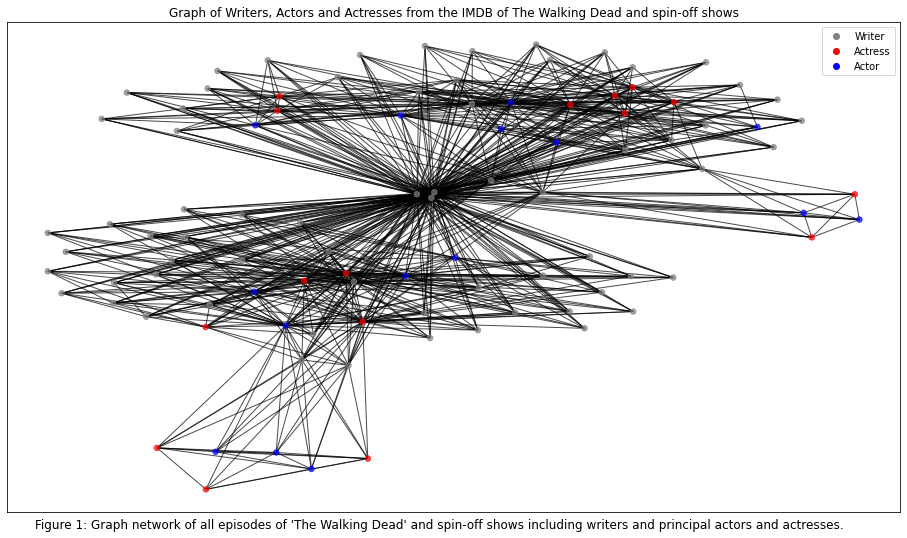

In [44]:
# code to create figure of network - will display as markdown to keep consistent and easier to reference in text.
# note figures have been saved by clicking on the save button, rather than plt.savefig() this is so I can embed them in md
from matplotlib.lines import Line2D

plt.figure(figsize=(16, 9))

nx.draw_networkx(
    G, node_color=node_color, node_size=30, width=1, with_labels=False, alpha=0.7
)
custom_lines = [
    Line2D([0], [0], color="gray", lw=4, marker="o", ls=""),
    Line2D([0], [0], color="red", lw=4, marker="o", ls=""),
    Line2D([0], [0], color="blue", lw=4, marker="o", ls=""),
]
plt.legend(custom_lines, ["Writer", "Actress", "Actor"])
plt.title(
    "Graph of Writers, Actors and Actresses from the IMDB of The Walking Dead and spin-off shows"
)


plt.figtext(
    0.5,
    0.1,
    "Figure 1: Graph network of all episodes of 'The Walking Dead' and spin-off shows including writers and principal actors and actresses.",
    wrap=True,
    horizontalalignment="center",
    fontsize=12,
)

At the centre of Figure 1, there are three writers, Charlie Adlard, Robert Kirkman and Tony Moore these are the show’s creators and therefore it is reasonable that they should be at the centre and well connected as they are associated with almost all episodes in the three-franchises. There are two distinct cliques that are to the far right and bottom middle; these are the two spin-off shows. Firstly, these shows have different actors than the main cast and fewer episodes in their respective shows, so the cluster forms small cliques. Furthermore, there are fewer writers and cast members so they are less well-connected and pushed to the periphery of the network. There is an actor and actress that link the left-most clique with the more central network.


<center />Table 2: Network statistics of the Walking Dead franchise IMDB dataset.

|statistic|Value|
|--|--|
|radius|2|
|diameter|3|
|average clustering|0.82|
|transivity|0.36|

The network is relatively small with a diameter of three and a radius of two, this is to be expected as there is only a subset of the actors/actresses in the dataset. The average clustering is also high which shows that for this subset of data throughout the many episodes of the show the actors and writers have often worked with each other. Conversely, the transitivity is low as there are few local clusters as the network is highly connected. If the dataset included all of the cast we would expect more cast members on the periphery of the network, where they would have only appeared in a low number of episodes. The dataset that has been created conforms to the small world hypothesis (Watts and Strogatz, 1998) whereby no node is more than 6 nodes from any other, in the case of this network it is three.

<a class="anchor" id="all-centrality"></a>

#### Measures of centrality.



In [45]:
# sorted dictionary by values in descending order to find the people who are most central
centrality_dict = {
    k: v
    for k, v in sorted(
        sorted(nx.degree_centrality(G).items()), key=lambda item: item[1], reverse=True
    )
}

In [46]:
# Only show labels where we have high centrality, also ignore three overlapping points in middle
tmp_labels = {}
for i in centrality_dict:
    if centrality_dict[i] > 0.40 and centrality_dict[i] < 0.9:
        tmp_labels[i] = pos[i]
    else:
        # hide labels outside of axis
        tmp_labels[i] = np.array([-10, 10])

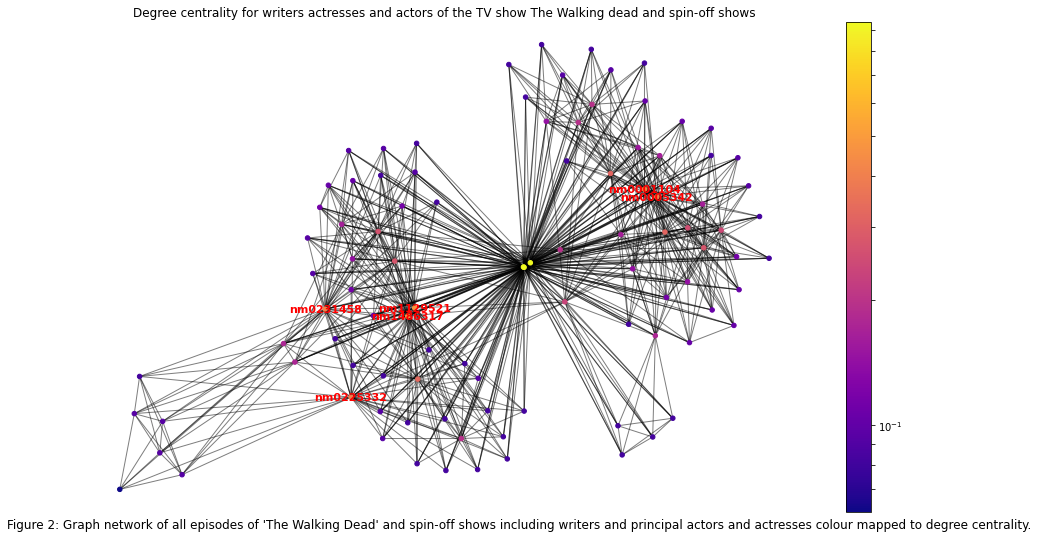

In [49]:
import matplotlib.colors as mcolors  # for producing colour bar

# create figure and graph
fig = plt.figure(figsize=(16, 9))
nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_size=20,
    cmap=plt.cm.plasma,
    node_color=list(nx.degree_centrality(G).values()),
    nodelist=nx.degree_centrality(G).keys(),
)

nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
# add labels to graph
labels = nx.draw_networkx_labels(
    G, tmp_labels, font_color="red", font_size=11, font_weight="bold"
)
# add edges to graph
edges = nx.draw_networkx_edges(G, pos, alpha=0.5)

plt.title(
    "Degree centrality for writers actresses and actors of the TV show The Walking dead and spin-off shows"
)
plt.colorbar(nodes)

plt.figtext(
    0.5,
    0.1,
    "Figure 2: Graph network of all episodes of 'The Walking Dead' and spin-off shows including writers and principal actors and actresses colour mapped to degree centrality.",
    wrap=True,
    horizontalalignment="center",
    fontsize=12,
)

plt.axis("off")
plt.show()

When looking at the degree centrality in Figure 2, there are three central nodes highlighted in yellow. These central nodes are nm1891501, nm3079117 and nm3877885 who are Charlie Adlard, Robert Kirkman, and Tony Moore the three creators of the original comic books series and subsequent writers of the TV show. Charlie Adlard, Robert Kirkman and Tony Moore have the highest degree of centrality (equation 1) in the network of 0.94. The Actress with the highest degree of centrality (0.48) is nm1486317, with the highest Actor being nm0005342 (0.42). Within the logic of TWD universe, neither of these is the main protagonist, "Rick Grimes" who ranks 11th in degree centrality at 0.32 is. As for the three creators of the original show, it is likely that by any measure of the network, they will rank the highest as they are associated with every episode in each of the different shows. The Actor with the most number of appearances in the franchise is nm0005342 (Norman Reedus as "Daryl Dixon"); this is due to his appearance in the greatest number of episodes (157), followed by nm0511088 ("Rick Grimes"). 

From the subset of actors and actresses, nm1486317 ("Alicia Clark") appears in the fourth most number of episodes, but more importantly, when considering the network as a whole has a greater number of connections. This is because Alicia Clark has connections with all the characters of the largest spin-off show and the writers from the "main show" as this network is dominated by writers due to only a subset of characters being available, she is ranked higher, by degree centrality, than more established characters within TWD universe. The character that appears in both the main series and the largest spin-off (nm0416694) is ranked 15th by degree centrality; it may be expected that if the larger dataset of characters were available that this character would rank higher as they would have a greater number of connections. Although the character that appears in both shows has the potential to be well connected, he is not a principal actor in many of the episodes and therefore does not make as many connections as may be expected. Had all the characters been in the dataset, it may be expected he would have the highest betweeness centrality as he would connect the two largest shows.

Considering the degree centrality, we can identify the three creators of the show as the most highly connected nodes. This is as expected as they are associated with each episode and, therefore, are associated with all the people in the network. However, with respect to the cast, the member with the highest degree centrality was not the main protagonist in any of the shows. When considering other measures, such as those in Table 3, we find that "Alicia Clark" is the most central character by any of the measures. Contrary to the author’s expectation, the characters in the largest "spin-off" show are more central than those that have appeared in many more shows in the main series. One reason for this is that the largest spin-off show, "Fear the Walking Dead", has a larger diversity of core characters and therefore develops more connections than the main show (Table 1). Furthermore, as writers for the main-show move on to work on the spin-off shows, the cast of FWD becomes connected to the central group. 

The closeness centrality (Equation 2), which measures how close a node is to all other nodes by averaging the shortest path lengths (Golbeck, 2013), is generally higher for those in FWD than TWD (Table 3). For betweenness centrality (Equation 3), which measures the flow of information through a network and by which the network would be most damaged if the central nodes were removed, are higher for those in FWD than those in TWD. Colman Domingo, who is the protagonist of FWD has a betweenness centrality of 0.054, whereas Norman Reedus, the actor who has appeared in most episodes, has a value of 0.016. In this network, the eigenvector centrality measures the importance of connections by accounting for the incoming connections of the neighbouring nodes (Hansen et al., 2020). However, as this is an undirected graph, the eigenvector centrality is similar to the degree centrality, if the nodes are connected, the connections are equal.



In [30]:
# measure the eigenvector centrality
centrality_eig_dict = {
    k: v
    for k, v in sorted(
        sorted(nx.eigenvector_centrality(G).items()),
        key=lambda item: item[1],
        reverse=True,
    )
}
# measure the closeness centrality
centrality_closeness_dict = {
    k: v
    for k, v in sorted(
        sorted(nx.closeness_centrality(G).items()),
        key=lambda item: item[1],
        reverse=True,
    )
}
# measure the betweeness centrality
centrality_betweeness_dict = {
    k: v
    for k, v in sorted(
        sorted(nx.betweenness_centrality(G).items()),
        key=lambda item: item[1],
        reverse=True,
    )
}

In [46]:
# temporary dataframe to view centrality measures
tmp = pd.DataFrame(centrality_dict.keys(), columns=["name"])
tmp["degree_centrality"] = centrality_dict.values()
tmp["eigen_centrality"] = tmp["name"].map(centrality_eig_dict)
tmp["closeness_centrality"] = tmp["name"].map(centrality_closeness_dict)
tmp["betweeness_centrality"] = tmp["name"].map(centrality_betweeness_dict)
# display top 12 -- commented to not show output
# tmp.merge(
#     df_dataset[["nconst", "primaryName", "category"]], left_on="name", right_on="nconst"
# ).drop(columns=["nconst"]).drop_duplicates().head(12).round(3).to_markdown()

<center />Table 3: Measures of centrality for top 12 cast and crew of TWD universe from IMDB.

|      | pk|degree  centrality |eigen centrality |closeness centrality |betweeness centrality|name|category|
|-----:|:----------|--------------------:|-------------------:|-----------------------:|------------------------:|:--------------------|:-----------|
|    0 | nm1891501 |               0.938 |              0.314 |                  0.942 |                   0.206 | Charlie Adlard      | writer     |
|  298 | nm3079117 |               0.938 |              0.314 |                  0.942 |                   0.206 | Robert Kirkman      | writer     |
|  596 | nm3877885 |               0.938 |              0.314 |                  0.942 |                   0.206 | Tony Moore          | writer     |
|  894 | nm1129521 |               0.485 |              0.179 |                  0.66  |                   0.024 | Dave Erickson       | writer     |
|  995 | nm1486317 |               0.485 |              0.179 |                  0.66  |                   0.024 | Alycia Debnam-Carey | actress    |
| 1096 | nm0001104 |               0.454 |              0.171 |                  0.622 |                   0.021 | Frank Darabont      | writer     |
| 1272 | nm0005342 |               0.423 |              0.164 |                  0.61  |                   0.016 | Norman Reedus       | actor      |
| 1429 | nm0231458 |               0.423 |              0.152 |                  0.634 |                   0.054 | Colman Domingo      | actor      |
| 1501 | nm0225332 |               0.402 |              0.143 |                  0.626 |                   0.052 | Kim Dickens         | actress    |
| 1548 | nm0226817 |               0.33  |              0.136 |                  0.599 |                   0.008 | Frank Dillane       | actor      |
| 1592 | nm0511088 |               0.32  |              0.134 |                  0.574 |                   0.008 | Andrew Lincoln      | actor      |
| 1711 | nm1659348 |               0.32  |              0.137 |                  0.574 |                   0.007 | Lauren Cohan        | actress    |



<hr>

<a class="anchor" id="cast-only"></a>

### Cast only network

In [50]:
cast_df = connections.query("actor_a_cat != 'writer' and actor_b_cat != 'writer'")

Text(0.8, -0.45, 'World Beyond')

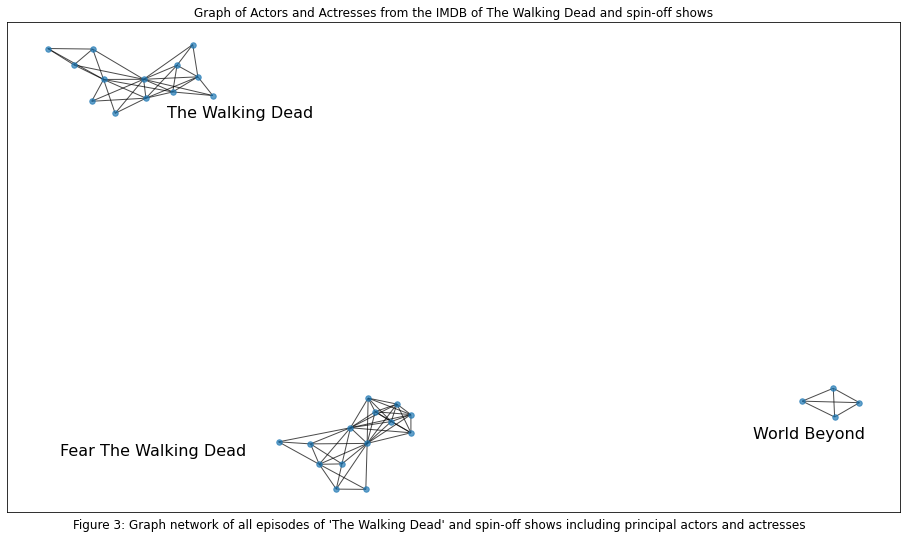

In [52]:
# Generate graph from dataframe
G2 = nx.from_pandas_edgelist(
    cast_df,
    source="actor_a",
    target="actor_b",
    create_using=nx.Graph(),
)
pos2 = nx.spring_layout(G2, seed=8)

# create figure
plt.figure(figsize=(16, 9))

nx.draw_networkx(G2, pos=pos2, node_size=30, width=1, with_labels=False, alpha=0.7)
# labels = nx.draw_networkx_labels(
#     G2, pos=pos2, font_color="red", font_size=11, font_weight="bold"
# )
plt.title(
    "Graph of Actors and Actresses from the IMDB of The Walking Dead and spin-off shows"
)
plt.figtext(
    0.5,
    0.1,
    "Figure 3: Graph network of all episodes of 'The Walking Dead' and spin-off shows including principal actors and actresses",
    wrap=True,
    horizontalalignment="center",
    fontsize=12,
)


plt.text(-0.3, 0.48, "The Walking Dead", fontsize=16)
plt.text(-0.5, -0.5, "Fear The Walking Dead", fontsize=16)
plt.text(0.8, -0.45, "World Beyond", fontsize=16)

In [85]:
nx.graph_clique_number(G2)

7

In [86]:
nx.graph_clique_number(G)

11


When only considering the cast, there is a disconnected graph with three components - one for each show. For WB, there are only four principal actors, and there is only one series of the show. Because of this, for WB, all the characters are connected to each other and form a clique (Seidman and Foster, 1978). For both FWD and TWD, who have similar-sized networks, the components do not have a shared actor and are, therefore, separate components. 

In figure 3, there are seven cliques, in comparison to 11 in Figure 2. The relatively small difference between the number of cliques between the networks with and without the writers shows that the characters tend to form cliques more than the writers. This may be due to the subset of the data, where we only have the four principal actors per episode, and therefore, the main characters in the story are likely to form cliques.


In [57]:
# measure the cast degree centrality
cast_centrality_dict = {
    k: v
    for k, v in sorted(
        sorted(nx.degree_centrality(G2).items()),
        key=lambda item: item[1],
        reverse=True,
    )
}
# measure the eigenvector centrality
cast_centrality_eig_dict = {
    k: v
    for k, v in sorted(
        sorted(nx.eigenvector_centrality(G2).items()),
        key=lambda item: item[1],
        reverse=True,
    )
}
# measure the closeness centrality
cast_centrality_closeness_dict = {
    k: v
    for k, v in sorted(
        sorted(nx.closeness_centrality(G2).items()),
        key=lambda item: item[1],
        reverse=True,
    )
}
# measure the betweeness centrality
cast_centrality_betweeness_dict = {
    k: v
    for k, v in sorted(
        sorted(nx.betweenness_centrality(G2).items()),
        key=lambda item: item[1],
        reverse=True,
    )
}

In [59]:
# temporay data frame to generate centrality measure for the cast
tmp = pd.DataFrame(cast_centrality_dict.keys(), columns=["name"])
tmp["degree centrality"] = cast_centrality_dict.values()
tmp["eigen_centrality"] = tmp["name"].map(cast_centrality_eig_dict)
tmp["closeness_centrality"] = tmp["name"].map(cast_centrality_closeness_dict)
tmp["betweeness_centrality"] = tmp["name"].map(cast_centrality_betweeness_dict)
# display top 12 -- commented to not show output
# tmp.merge(
#     df_dataset[["nconst", "primaryName", "category"]], left_on="name", right_on="nconst"
# ).drop(columns=["nconst"]).drop_duplicates().head(12).round(3).to_markdown()

In [89]:
nx.info(G2)

'Graph with 31 nodes and 84 edges'

<center />Table 4: The centrallity measures for the top 12 cast of The Walking dead and spin-off shows

|     | pk      |   degree centrality |   eigen centrality |   closeness centrality |   betweeness centrality | name         | category   |
|----:|:----------|--------------------:|-------------------:|-----------------------:|------------------------:|:--------------------|:-----------|
|   0 | nm0231458 |               0.4   |              0.405 |                  0.402 |                   0.053 | Colman Domingo      | actor      |
|  72 | nm0005342 |               0.367 |              0     |                  0.369 |                   0.06  | Norman Reedus       | actor      |
| 229 | nm0225332 |               0.367 |              0.391 |                  0.376 |                   0.036 | Kim Dickens         | actress    |
| 276 | nm0511088 |               0.267 |              0     |                  0.3   |                   0.026 | Andrew Lincoln      | actor      |
| 395 | nm0001952 |               0.233 |              0.313 |                  0.296 |                   0     | Rubén Blades        | actor      |
| 397 | nm0172558 |               0.233 |              0.313 |                  0.296 |                   0     | Mo Collins          | actress    |
| 399 | nm1314042 |               0.233 |              0.313 |                  0.296 |                   0     | Karen David         | actress    |
| 401 | nm1486317 |               0.233 |              0.2   |                  0.296 |                   0.011 | Alycia Debnam-Carey | actress    |
| 502 | nm1659348 |               0.233 |              0     |                  0.282 |                   0.009 | Lauren Cohan        | actress    |
| 617 | nm3994184 |               0.233 |              0.313 |                  0.296 |                   0     | Austin Amelio       | actor      |
| 619 | nm0001184 |               0.2   |              0.279 |                  0.282 |                   0     | Jenna Elfman        | actress    |
| 620 | nm0564350 |               0.2   |              0     |                  0.253 |                   0.004 | Melissa McBride     | actress    |



In [99]:
# example of calculating graph and centrality for TWD
G3 = nx.from_pandas_edgelist(
    connections.query(
        "parentTconst == 'tt1520211' and actor_a_cat != 'writer' and actor_b_cat != 'writer'"
    ),
    source="actor_a",
    target="actor_b",
    create_using=nx.Graph(),
)

nx.eigenvector_centrality(G3)

{'nm0005342': 0.4720990052081298,
 'nm0564350': 0.30700319064779,
 'nm1659348': 0.3629729840577958,
 'nm1589312': 0.2797875570621264,
 'nm0511088': 0.35211522569859666,
 'nm1256532': 0.12503584184145353,
 'nm0915637': 0.19336568049427416,
 'nm0390229': 0.19336568049427416,
 'nm3081796': 0.20090784080615226,
 'nm3385128': 0.20090784080615226,
 'nm1775091': 0.33203123759073894,
 'nm1315153': 0.18803666413327688,
 'nm3129311': 0.17919539191052436}

When considering only the cast of each show, the centrality measures are fairly similar in identifying who are the central characters. Colman Domingo, the main protagonist in FWD and Norman Reedus from TWD, who is not necessarily the main protagonist but has been in the greatest number of episodes, is at the top. Given the fact that Norman Reedus has been in most episodes and is a "principal character," it could be argued that he is the main protagonist in TWD. Colman Domingo is certainly the main protagonist for FWB. For the characters in WB, the centrality measures do not offer any insight into who the key characters are, and they can all be considered equal.

 

<hr>

<a class="anchor" id="conclusion"></a>

# Conclusion

From the results that have been presented, a good case can be made for either Norman Reedus or Colman Domingo to be the main protagonist within the Walking Dead universe. However, within the logic of the universe Norman Reedus' character is more of a soldier and is not the focus of the story, but he has been in most episodes as a principal actor. Colman Domingo is in a show that has fewer episodes and potentially fewer characters who could be "principal actors", and therefore, within FWD, he is clearly the protagonist; he is also the *current* protagonist within the logic of the show. In comparison to the writers, something that cannot be captured by the cast is the temporal nature of the protagonists as characters leave and new ones are introduced. Without giving a weighting for the perceived importance of a character to the show’s plot, it is hard to pinpoint who the key character is for the Walking Dead Universe, which would arguably be Rick Grimes (Andrew Lincoln). The approach taken here, somewhat dictated by the available data, preferences characters that have survived the longest and therefore been in episodes with other key actors most often, which isn't necessarily a marker of who is the main character.

From this analysis, the show’s creators were clearly identified as the central nodes (Figure 1) and were the most important by any measure (Table 3). Although it was a trivial case to identify the show’s creators as the key influencers in the network, it does highlight the power of social network analysis. Furthermore, the analysis made a strong case as to who the main protagonists are within the Walking Dead universe in its current state. Although within the universe, the main protagonists are somewhat subjective, it could be argued that characters in TWD should have more weight as it is a higher profile show in terms of viewing figures and that it was the original. If we had not conducted this analysis and simply counted the number of episodes Colman Domingo and the cast from FWD would not have been as prominent as there are 46 fewer episodes. Given the relatively small nature of the network, in terms of radius and diameter (Table 2), the measures of centrality were fairly similar, with the same characters generally ranking the same for each measure.

<a class="anchor" id="further-work"></a>

### Further work

Further work could look at collecting more characters from the show or going to the original comic book source material and comparing that with the TV series. Furthermore, a weighting for the characters and the nature of their interactions could be developed so that the key characters with respect to the story could be identified. Given that the shows are relatively volatile, with characters perishing and new ones being introduced, techniques for measuring the temporal changes and character development would be interesting to explore, such as those done by Prado et al., (2016). It is suspected that by accounting for a weighting of types of interaction and time-averaged centralities, the main protagonist would be Rick Grimes.





<a class="anchor" id="tests"></a>

# Tests

Unit tests for functions used in this notebook

In [100]:
import unittest
import pandas.testing as pd_testing

# Unit test to check if we are creating the correct combinations of actors
class TestNotebook(unittest.TestCase):
    # Store the expected answer
    def setUp(self) -> None:
        self.connections_answer = pd.DataFrame(
            {
                "tconst": ["show1"] * 3,
                "actor_a": ["A", "A", "B"],
                "actor_b": ["B", "C", "C"],
            }
        )

    # test function using pandas testing
    def test_create_connections(self) -> None:
        try:
            pd_testing.assert_frame_equal(
                # call the function we want to test
                create_connections(
                    pd.DataFrame(
                        {
                            "tconst": ["show1", "show1", "show1"],
                            "nconst": ["A", "B", "C"],
                        }
                    )
                ),
                # correct answer
                self.connections_answer,
            )
        except AssertionError as e:
            raise self.failureException(
                "Error, there is an issue with this function"
            ) from e


# run test
unittest.main(argv=[""], verbosity=2, exit=False)

test_create_connections (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.009s

OK


<a class="anchor" id="references"></a>

# References

Bazzan, A.L.C. (2020). I will be there for you: clique, character centrality, and community detection in Friends. Computational and Applied Mathematics, 39(3). doi:10.1007/s40314-020-01222-7.

Beveridge, A. and Shan, J. (2016). Network of Thrones. Math Horizons, 23(4), pp.18–22. doi:10.4169/mathhorizons.23.4.18.

Golbeck, J. (2013). Network Structure and Measures. Analyzing the Social Web, pp.25–44. doi:10.1016/b978-0-12-405531-5.00003-1.

Hansen, D.L., Shneiderman, B., Smith, M.A. and Himelboim, I. (2020). Social network analysis: Measuring, mapping, and modeling collections of connections. Analyzing Social Media Networks with NodeXL, pp.31–51. doi:10.1016/b978-0-12-817756-3.00003-0.

Prado, S.D., Dahmen, S.R., Bazzan, A.L.C., Carron, P.M. and Kenna, R. (2016). Temporal network analysis of literary texts. Advances in Complex Systems, 19(03), p.1650005. doi:10.1142/s0219525916500053.

Seidman, S.B. and Foster, B.L. (1978). A graph‐theoretic generalization of the clique concept. The Journal of Mathematical Sociology, 6(1), pp.139–154. doi:10.1080/0022250x.1978.9989883.

Watts, D.J. and Strogatz, S.H. (1998). Collective dynamics of ‘small-world’ networks. Nature, 393(6684), pp.440–442. doi:10.1038/30918.

<a class="anchor" id="equations"></a>

# Equations

Degree centrality, where A is the adjaceny matrix i are rows and j are columns: $ \begin{equation}\tag{1}C_D(j) = \sum_{j= 1}^{n}A_{ij}\end{equation} $

Closeness centrality, i are rows and j are columns and d(i,j) is the shortest path between nodes i and j: $ \begin{equation}\tag{2}CC(i) = \frac{n-1}{\sum_{j}d(i,j)}\end{equation} $

Betweeness centrality, where v,s and t are different nodes :$ \begin{equation}\tag{3}g(v) =  \sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}\end{equation} $